In [1]:
%matplotlib inline

# StackingClassifier

An ensemble-learning meta-classifier for stacking.

> from mlxtend.classifier import StackingClassifier

# Overview

Stacking is an ensemble learning technique to combine multiple classification models via a meta-classifier. The individual classification models are trained based on the complete training set; then, the meta-classifier is fitted based on the outputs -- meta-features -- of the individual classification models in the ensemble.
The meta-classifier can either be trained on the predicted class labels or probabilities from the ensemble.

![](./StackingClassifier_files/stackingclassification_overview.png)

The algorithm can be summarized as follows (source: [1]):
    
![](./StackingClassifier_files/stacking_algorithm.png)

### References


- [1] Tang, J., S. Alelyani, and H. Liu. "[Data Classification: Algorithms and Applications.](https://books.google.com/books?id=nwQZCwAAQBAJ&lpg=PA500&dq=stacking%20classifier%20subsets&pg=PA499#v=onepage&q&f=false)" Data Mining and Knowledge Discovery Series, CRC Press (2015): pp. 498-500.
- [2] Wolpert, David H. "[Stacked generalization.](http://www.sciencedirect.com/science/article/pii/S0893608005800231)" Neural networks 5.2 (1992): 241-259.

## Example 1 - Simple Stacked Classification

In [2]:
from sklearn import datasets

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

In [3]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
import numpy as np

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X, y, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.91 (+/- 0.06) [Random Forest]
Accuracy: 0.92 (+/- 0.03) [Naive Bayes]
Accuracy: 0.95 (+/- 0.03) [StackingClassifier]


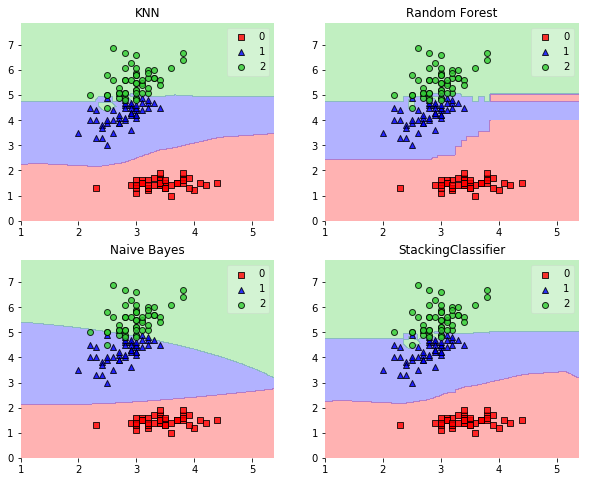

In [4]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8))

for clf, lab, grd in zip([clf1, clf2, clf3, sclf], 
                         ['KNN', 
                          'Random Forest', 
                          'Naive Bayes',
                          'StackingClassifier'],
                          itertools.product([0, 1], repeat=2)):

    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(lab)

## Example 2 - Using Probabilities as Meta-Features

Alternatively, the class-probabilities of the first-level classifiers can be used to train the meta-classifier (2nd-level classifier) by setting `use_probas=True`. If `average_probas=True`, the probabilities of the level-1 classifiers are averaged, if `average_probas=False`, the probabilities are stacked (recommended). For example, in a 3-class setting with 2 level-1 classifiers, these classifiers may make the following "probability" predictions for 1 training sample:

- classifier 1: [0.2, 0.5, 0.3]
- classifier 2: [0.3, 0.4, 0.4]

If `average_probas=True`, the meta-features would be:

- [0.25, 0.45, 0.35]

In contrast, using `average_probas=False` results in k features where, k = [n_classes * n_classifiers], by stacking these level-1 probabilities:

- [0.2, 0.5, 0.3, 0.3, 0.4, 0.4]


In [5]:
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3],
                          use_probas=True,
                          average_probas=False,
                          meta_classifier=lr)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X, y, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.91 (+/- 0.06) [Random Forest]
Accuracy: 0.92 (+/- 0.03) [Naive Bayes]
Accuracy: 0.94 (+/- 0.03) [StackingClassifier]


## Example 3 - Stacked Classification and GridSearch

To set up a parameter grid for scikit-learn's `GridSearch`, we simply provide the estimator's names in the parameter grid -- in the special case of the meta-regressor, we append the `'meta-'` prefix.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingClassifier

# Initializing models

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

params = {'kneighborsclassifier__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta-logisticregression__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(X, y)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

0.667 +/- 0.00 {'kneighborsclassifier__n_neighbors': 1, 'meta-logisticregression__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.667 +/- 0.00 {'kneighborsclassifier__n_neighbors': 1, 'meta-logisticregression__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.927 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta-logisticregression__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.913 +/- 0.03 {'kneighborsclassifier__n_neighbors': 1, 'meta-logisticregression__C': 10.0, 'randomforestclassifier__n_estimators': 50}
0.667 +/- 0.00 {'kneighborsclassifier__n_neighbors': 5, 'meta-logisticregression__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.667 +/- 0.00 {'kneighborsclassifier__n_neighbors': 5, 'meta-logisticregression__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.933 +/- 0.02 {'kneighborsclassifier__n_neighbors': 5, 'meta-logisticregression__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.940 +/- 0.02 {'kneighborsclassifier__n_neighbors':

In case we are planning to use a regression algorithm multiple times, all we need to do is to add an additional number suffix in the parameter grid as shown below:

In [7]:
from sklearn.model_selection import GridSearchCV

# Initializing models

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf1, clf2, clf3], 
                          meta_classifier=lr)

params = {'kneighborsclassifier-1__n_neighbors': [1, 5],
          'kneighborsclassifier-2__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta-logisticregression__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(X, y)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

0.667 +/- 0.00 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta-logisticregression__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.667 +/- 0.00 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta-logisticregression__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.907 +/- 0.03 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta-logisticregression__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.913 +/- 0.03 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta-logisticregression__C': 10.0, 'randomforestclassifier__n_estimators': 50}
0.667 +/- 0.00 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 5, 'meta-logisticregression__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.667 +/- 0.00 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 5, 'me

## Example 4 - Stacking of Classifiers that Operate on Different Feature Subsets

The different level-1 classifiers can be fit to different subsets of features in the training dataset. The following example illustrates how this can be done on a technical level using scikit-learn pipelines and the `ColumnSelector`:

In [1]:
from sklearn.datasets import load_iris
from mlxtend.classifier import StackingClassifier
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

iris = load_iris()
X = iris.data
y = iris.target

pipe1 = make_pipeline(ColumnSelector(cols=(0, 2)),
                      LogisticRegression())
pipe2 = make_pipeline(ColumnSelector(cols=(1, 2, 3)),
                      LogisticRegression())

sclf = StackingClassifier(classifiers=[pipe1, pipe2], 
                          meta_classifier=LogisticRegression())

sclf.fit(X, y)

StackingClassifier(average_probas=False,
          classifiers=[Pipeline(steps=[('columnselector', ColumnSelector(cols=(0, 2))), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solve...='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])],
          meta_classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          use_features_in_secondary=False, use_probas=False, verbose=0)

# API

In [8]:
with open('../../api_modules/mlxtend.classifier/StackingClassifier.md', 'r') as f:
    print(f.read())

## StackingClassifier

*StackingClassifier(classifiers, meta_classifier, use_probas=False, average_probas=False, verbose=0, use_features_in_secondary=False)*

A Stacking classifier for scikit-learn estimators for classification.

**Parameters**

- `classifiers` : array-like, shape = [n_classifiers]

    A list of classifiers.
    Invoking the `fit` method on the `StackingClassifer` will fit clones
    of these original classifiers that will
    be stored in the class attribute
    `self.clfs_`.

- `meta_classifier` : object

    The meta-classifier to be fitted on the ensemble of
    classifiers

- `use_probas` : bool (default: False)

    If True, trains meta-classifier based on predicted probabilities
    instead of class labels.

- `average_probas` : bool (default: False)

    Averages the probabilities as meta features if True.

- `verbose` : int, optional (default=0)

    Controls the verbosity of the building process.
    - `verbose=0` (default): Prints nothing
    - `verbose=1`: